In [1]:
import matplotlib.pyplot as plt
import numpy as np
from abc import ABC

import os, sys
sys.path.append("..")
from seeding import np_random
import bezier
from track.generate_random import Base_TrackGenerator, Random_TrackGenerator

FIGURE_PATH=r'C:\Users\7459985\Desktop\2025\RDDS\001_code\meow_racer\step_1_rl\envs_2\debug\figures_0406'.replace('\\', '/')

In [2]:
a = True
b = True
a &= b
print(a)

True


In [2]:
class Bezier_TrackGenerator(Random_TrackGenerator):
    def __init__(self,
                 min_num_ckpt:int, 
                 max_num_ckpt:int,
                 min_kappa:float=0.04,
                 max_kappa:float=0.1,
                 track_width:float=7.,
                 track_density:int=1,
                 track_radius:float=200.,
                 scale_rate:float=1.,
                 ):
        '''Random Track Generation with Bezier Curve Fitting
        
        '''
        super().__init__(min_num_ckpt=min_num_ckpt, max_num_ckpt=max_num_ckpt,
                         track_radius=track_radius, scale_rate=scale_rate,
                         track_width=track_width)
        self.track_density = track_density
        self.min_kappa = min_kappa
        self.max_kappa = max_kappa
        
    def _generate(self):
        success = False
        while not success:
            self._reset()
            self._create_checkpoints()
            success = self._validate_checkpoints()
            self._connect_checkpoints()
            success &= self._check_intersection()
            success &= self._validate_kappa()
    
    def _get_track_beta(self):
        phi_arr = self._get_track_phi()
        return phi_arr - np.pi/2
     
    def _calculate_track_dict(self):
        self.cX, self.cY = self._get_track_center()
        self.vertice_arr, self.left_arr, self.right_arr = self._get_track_sides()
        self.kappa_arr = self._get_track_kappa()
        self.theta_arr = self._get_track_theta()
        self.phi_arr = self._get_track_phi()
        self.beta_arr = self._get_track_beta()
        
        track_dict = {
            'theta': self.theta_arr,
            'phi': self.phi_arr,
            'beta': self.beta_arr,
            'kappa': self.kappa_arr,
            'x': self.cX, 'y': self.cY,
            'vertices': self.vertice_arr,
            'left': self.left_arr,
            'right': self.right_arr
        }
        
        return track_dict
            
    def _get_track_center(self):
        return self.cX, self.cY
    
    def _check_intersection(self):
        for i in range(len(self.curves)-1):
            for j in range(i+1, len(self.curves)):
                inter = self.curves[i].intersect(self.curves[j])
                if len(inter.T) > 1:
                    return False

        return True
    
    def _validate_kappa(self):
        '''너무 급격한 curve는 피하도록,
        그렇지만 남양 트랙의 hair pin corner에 해당하는 난이도의 corner은 무조건 포함해야 함'''
        kappa = self._get_track_kappa()
        if len(np.where(np.abs(kappa) > self.max_kappa)[0]) > 0:
            return False
        if len(np.where(np.abs(kappa) > self.min_kappa)[0]) == 0:
            return False
        
        return True
    
    def _validate_checkpoints(self):
        for i, (alpha, _, _, _) in enumerate(self.checkpoints):
            if alpha > np.pi * 2:
                break
            
        self.checkpoints = self.checkpoints[:i]
        if len(self.checkpoints) < 3:
            return False
        return True
    
    def _connect_checkpoints(self):
        X, Y = np.array(self.checkpoints).T[1], np.array(self.checkpoints).T[2]
        self.initial_coords = np.array(self.checkpoints).T[1:3]
        
        arr = np.vstack((X, Y)).T
        mids = (arr[:-1] + arr[1:]) / 2
        last = 0.5 * (arr[0] + arr[-1])

        mid_points = np.concatenate([mids, [last]])
        
        final_points = None

        mid_X, mid_Y = mid_points.T[0],mid_points.T[1]
        all_X, all_Y = np.zeros(len(mid_X)*2), np.zeros(len(mid_Y)*2)
        np.put(all_X, [i for i in range(1, len(mid_X)*2, 2)], np.concatenate([X[1:], [X[0]]]));np.put(all_X, [i for i in range(0, len(mid_X)*2, 2)], mid_X)
        np.put(all_Y, [i for i in range(1, len(mid_Y)*2, 2)], np.concatenate([Y[1:], [Y[0]]]));np.put(all_Y, [i for i in range(0, len(mid_Y)*2, 2)], mid_Y)

        x_arr = np.hstack((all_X, all_X))
        y_arr = np.hstack((all_Y, all_Y))

        self.all_X = all_X
        self.all_Y = all_Y
        
        curves = []
        
        for start_idx in range(0, len(all_X), 2):
            end_idx = start_idx + 3
    
            nodes = np.asfortranarray([
                x_arr[start_idx:end_idx], y_arr[start_idx:end_idx]
            ])
            curve = bezier.Curve(nodes, degree=2)
    
            mx, Mx = min(x_arr[start_idx:end_idx]), max(x_arr[start_idx:end_idx])
            my, My = min(y_arr[start_idx:end_idx]), max(y_arr[start_idx:end_idx])
            diffX, diffY = Mx-mx, My-my
            diff_val = max(diffX, diffY)
            s_vals = np.linspace(0., 1., int(diff_val)*self.track_density)
            points = curve.evaluate_multi(s_vals)
       
            if final_points is None:
                final_points = points
            else:
                final_points = np.hstack((final_points, points[:, 1:]))

            curves.append(curve)
            
        self.final_points = final_points
        self.cX = final_points[0]
        self.cY = final_points[1]
        
        self.curves = curves
        
            
    

In [45]:
bezier_track = Bezier_TrackGenerator(
    min_num_ckpt=4,
    max_num_ckpt=16,
    track_radius=200,
    scale_rate=1.,
    min_kappa=0.05,
    max_kappa=0.1,
)
# bezier_track._reset()
bezier_track._generate()

In [46]:
ckpts = bezier_track.checkpoints
print(len(ckpts))
track_dict = bezier_track._calculate_track_dict()

11


In [5]:
track_dict.keys()

dict_keys(['theta', 'phi', 'beta', 'kappa', 'x', 'y', 'vertices', 'left', 'right'])

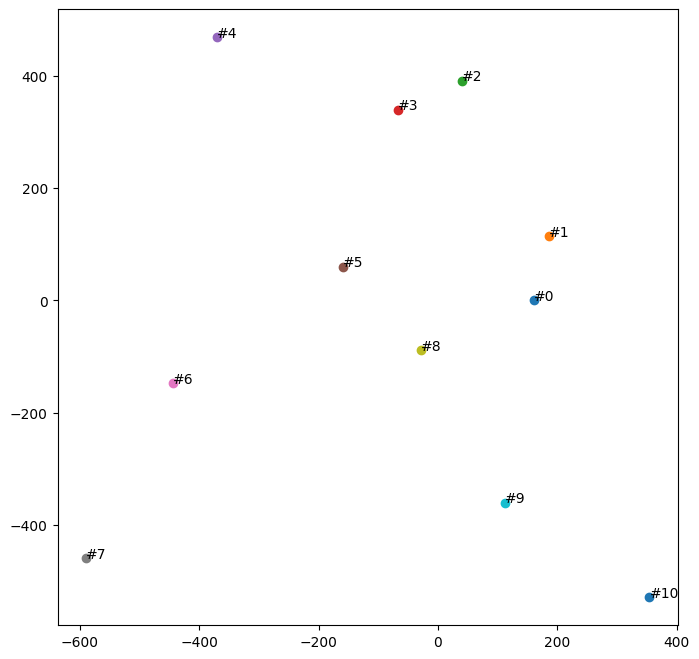

In [47]:
dx = max(track_dict['x']) - min(track_dict['x'])
dy = max(track_dict['y']) - min(track_dict['y'])
fig, ax = plt.subplots(figsize=(8, int(8 * (dy/dx))))

for i, (_, x,y, _) in enumerate(bezier_track.checkpoints):
    plt.scatter(x, y);plt.text(x, y, f"#{i}")

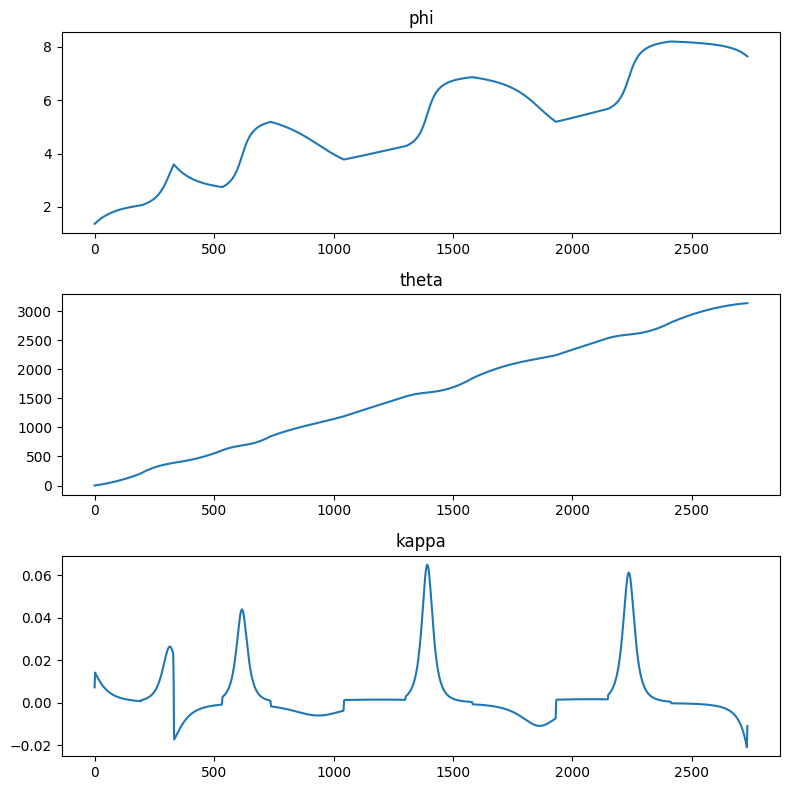

In [48]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8))
ax[0].plot(track_dict['phi']);ax[0].set_title("phi")
ax[1].plot(track_dict['theta']);ax[1].set_title("theta")
ax[2].plot(track_dict['kappa']);ax[2].set_title("kappa")
plt.tight_layout()

In [9]:
from scipy.signal import find_peaks

peaks = find_peaks(np.abs(track_dict['kappa']), distance=50)
peaks

(array([  68,  191,  498,  864,  980, 1184, 1250, 1508, 1662, 2112, 2309,
        2762]),
 {})

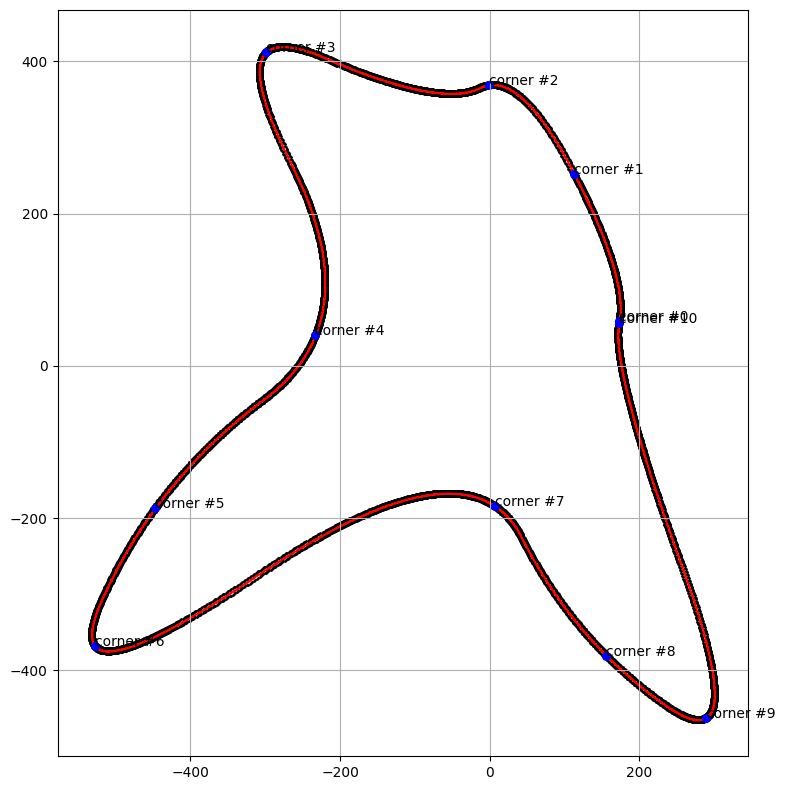

In [49]:
dx = max(track_dict['x']) - min(track_dict['x'])
dy = max(track_dict['y']) - min(track_dict['y'])
fig, ax = plt.subplots(figsize=(8, int(8 * (dy/dx))))
for i in range(len(track_dict['x'])):
    
    plt.scatter(track_dict['x'][i], track_dict['y'][i], s=1, c='r')
    plt.scatter(track_dict['left'][i][0], track_dict['left'][i][1], s=1, c='k')
    plt.scatter(track_dict['right'][i][0], track_dict['right'][i][1], s=1, c='k')

plt.scatter(track_dict['x'][0], track_dict['y'][0], s=30, c='g')

# corners = np.where(np.abs(track_dict['kappa'] > 0.02))
peaks = find_peaks(np.abs(track_dict['kappa']), distance=50)

for i, peak in enumerate(peaks[0]):
    plt.scatter(track_dict['x'][peak], track_dict['y'][peak], s=30, c='b')
    plt.text(track_dict['x'][peak], track_dict['y'][peak], f"corner #{i}")

plt.tight_layout()
plt.grid(True)
plt.savefig(f"{FIGURE_PATH}/bezier_track.png")

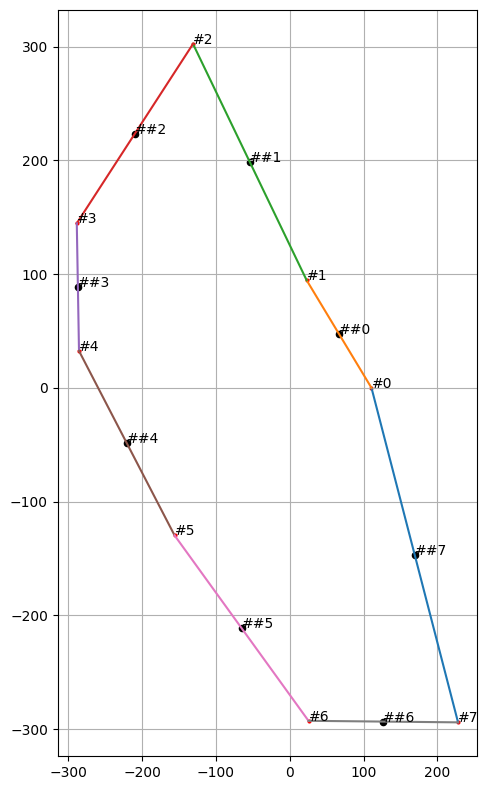

In [63]:
fig, ax = plt.subplots(figsize=(5, 8))
for i, (alpha, x, y, rad) in enumerate(ckpts):
    plt.scatter(x, y, c='r', s=4)
    plt.text(x=x, y=y, s=f"#{i}")
X, Y = np.array(ckpts).T[1], np.array(ckpts).T[2]
for i in range(len(X)):
    plt.plot([X[i], X[i-1]], [Y[i], Y[i-1]])

arr = np.vstack((X, Y)).T
mids = (arr[:-1] + arr[1:]) / 2
last = 0.5 * (arr[0] + arr[-1])

mid_points = np.concatenate([mids, [last]])

for mi, (mx, my) in enumerate(mid_points):
    plt.scatter(mx, my, s=20, c='k')
    plt.text(mx, my, s=f"##{mi}")
plt.grid(True)
plt.tight_layout()

In [16]:
import bezier
import numpy as np
nodes = np.asfortranarray([
     X[0:3],
     Y[0:3],
])
curve = bezier.Curve(nodes, degree=2)

In [44]:
import matplotlib;matplotlib.colormaps['hsv'](0.2)

(0.8187488187488188, 1.0, 0.0, 1.0)

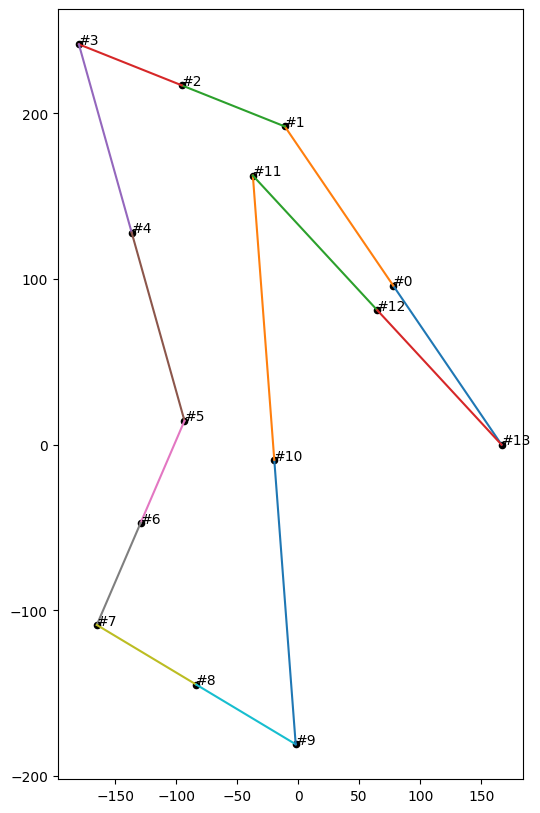

In [27]:
fig, ax =plt.subplots(figsize=(6, 10))

for i in range(len(all_X)):
    plt.scatter(all_X[i], all_Y[i], c='k', s=20)
    plt.text(all_X[i], all_Y[i], s=f"#{i}")
    plt.plot([all_X[i], all_X[i-1]], [all_Y[i], all_Y[i-1]])

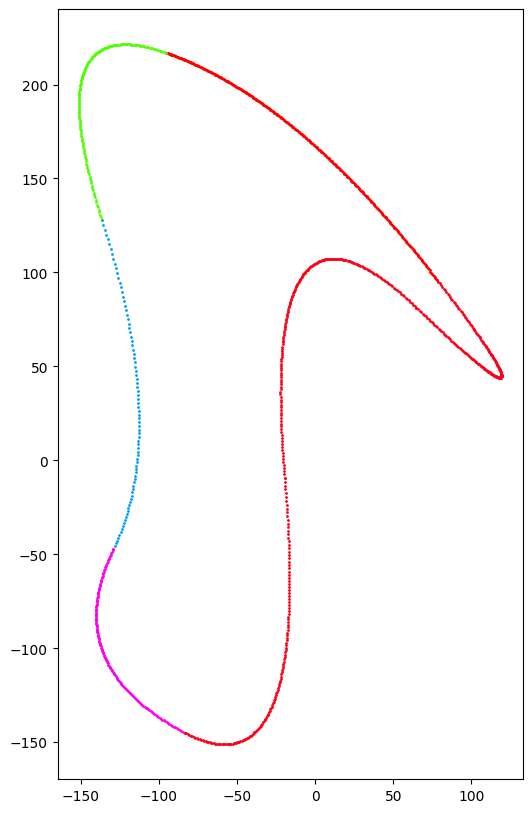

In [25]:
import bezier
import numpy as np
import matplotlib
cmap = matplotlib.colors.Colormap('hsv')

mid_X, mid_Y = mid_points.T[0],mid_points.T[1]
all_X, all_Y = np.zeros(len(mid_X)*2), np.zeros(len(mid_Y)*2)
np.put(all_X, [i for i in range(1, len(mid_X)*2, 2)], np.concatenate([X[1:], [X[0]]]));np.put(all_X, [i for i in range(0, len(mid_X)*2, 2)], mid_X)
np.put(all_Y, [i for i in range(1, len(mid_Y)*2, 2)], np.concatenate([Y[1:], [Y[0]]]));np.put(all_Y, [i for i in range(0, len(mid_Y)*2, 2)], mid_Y)

x_arr = np.hstack((all_X, all_X))
y_arr = np.hstack((all_Y, all_Y))

fig, ax =plt.subplots(figsize=(6, 10))

for start_idx in range(0, len(all_X), 2):
    # end_idx = (start_idx+3)%len(X)
    end_idx = start_idx + 3
    
    nodes = np.asfortranarray([
        x_arr[start_idx:end_idx], y_arr[start_idx:end_idx]
    ])
    curve = bezier.Curve(nodes, degree=2)
    
    mx, Mx = min(x_arr[start_idx:end_idx]), max(x_arr[start_idx:end_idx])
    s_vals = np.linspace(0., 1., int(Mx-mx)*2)
    points = curve.evaluate_multi(s_vals)
    
    for i, (px, py) in enumerate(points.T):
        plt.scatter(px, py, s=1, color=matplotlib.colormaps['hsv'](start_idx / len(X)))

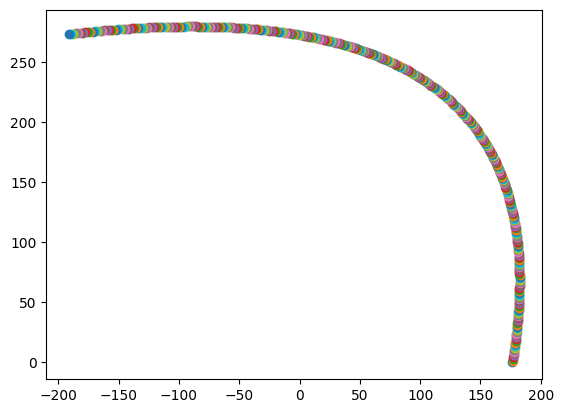

In [34]:
for i, (px, py) in enumerate(points.T):
    plt.scatter(px, py)

<Axes: >

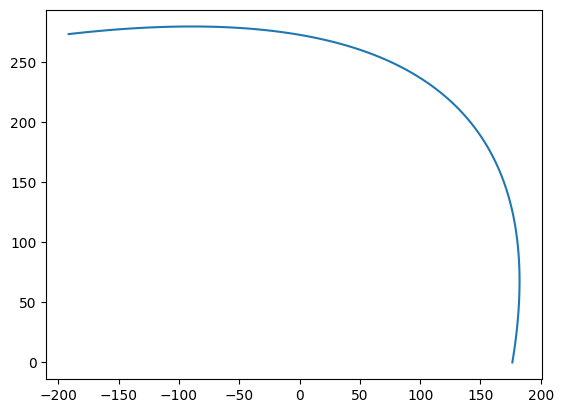

In [17]:
curve.plot(100)